In [1]:
import numpy as np
import gzip
import os

# 指定本地文件路径
data_dir = "..\\assets\\MNIST\\raw"
filenames = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
data = []

for filename in filenames:
    filepath = os.path.join(data_dir, filename)
    print("Loading", filepath)
    with gzip.open(filepath, 'rb') as f:
        if 'labels' in filename:
            # 读取标签数据，偏移量为8字节
            data.append(np.frombuffer(f.read(), np.uint8, offset=8))
        else:
            # 读取图像数据，偏移量为16字节，并转换为 (num_samples, 28*28)
            data.append(np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28))

# 分割训练和测试数据
X_train, y_train, X_test, y_test = data

# 归一化像素值到 [0,1] 之间
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# 转换标签为整数类型
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

print("Data loaded successfully!")

Loading ..\assets\MNIST\raw\train-images-idx3-ubyte.gz
Loading ..\assets\MNIST\raw\train-labels-idx1-ubyte.gz
Loading ..\assets\MNIST\raw\t10k-images-idx3-ubyte.gz
Loading ..\assets\MNIST\raw\t10k-labels-idx1-ubyte.gz
Data loaded successfully!


In [2]:
import matplotlib.pyplot as plt
def show_images(images, labels):
    """
    Display a set of images and their labels using matplotlib.
    The first column of `images` should contain the image indices,
    and the second column should contain the flattened image pixels
    reshaped into 28x28 arrays.
    """
    # Extract the image indices and reshaped pixels
    pixels = images.reshape(-1, 28, 28)

    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=len(images), nrows=1, figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the image and its label
        axs[i].imshow(pixels[i], cmap="gray")
        axs[i].set_title("Label: {}".format(labels[i]))

        # Remove the tick marks and axis labels
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("Index: {}".format(i))

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

In [3]:
import torch.nn as nn
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
class AutoEncoder(nn.Module):
    def __init__(self,num_hidden = 8):
        super().__init__()
        
        # 设置隐藏层神经元的数量（即潜在表示的维度）
        self.num_hidden = num_hidden
        
        # 定义自编码器的编码器部分
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),  # 输入维度 784（28x28 像素），映射到 256 维
            nn.ReLU(),  # 采用 ReLU 激活函数，引入非线性
            nn.Linear(256, self.num_hidden),  # 进一步压缩到 num_hidden 维
            nn.ReLU(),  # 再次使用 ReLU 激活函数，增强特征表达能力
        )
        
        # 定义自编码器的解码器部分
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),  # 从 num_hidden 维度恢复到 256 维
            nn.ReLU(),  # 采用 ReLU 激活函数，引入非线性
            nn.Linear(256, 784),  # 从 256 维恢复到 784 维，与原始输入大小一致
            nn.Sigmoid(),  # 使用 Sigmoid 将输出值压缩到 (0,1) 范围，适用于归一化后的像素数据
        )

    def forward(self, x):
        """
        前向传播过程：
        1. 输入数据经过编码器,得到潜在空间表示(encoded)
        2. 潜在表示再通过解码器，恢复为原始输入的近似值(decoded)。
        """
        encoded = self.encoder(x)  # 通过编码器得到潜在表示
        decoded = self.decoder(encoded)  # 通过解码器恢复原始数据
        return encoded, decoded  # 返回潜在表示和重建的输出

In [5]:
class VAE(AutoEncoder):
    def __init__(self):
        super().__init__()
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(z)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)
            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z)
        # Return the generated samples
        return samples

In [6]:

import torch.nn.functional as F

# Define a loss function that combines binary cross-entropy and Kullback-Leibler divergence
def loss_function(recon_x, x, mu, logvar):
    # Compute the binary cross-entropy loss between the reconstructed output and the input data
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Combine the two losses by adding them together and return the result
    return BCE + KLD

In [7]:

learning_rate=1e-3
num_epochs=10
batch_size=32
# Convert the training data to PyTorch tensors
X_train = torch.from_numpy(X_train).to(device)



In [61]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.MSELoss(reduction="sum")

# Create a DataLoader to handle batching of the training data
train_loader = torch.utils.data.DataLoader(
    X_train, batch_size=batch_size, shuffle=True
)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        # Get a batch of training data and move it to the device
        data = data.to(device)

        # Forward pass
        encoded, decoded, mu, log_var = model(data)

        # Compute the loss and perform backpropagation
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = criterion(decoded, data)+   KLD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )

Epoch 1/10: loss=1345.0090
Epoch 2/10: loss=1304.5149
Epoch 3/10: loss=1289.9907
Epoch 4/10: loss=1279.1496
Epoch 5/10: loss=1270.2095
Epoch 6/10: loss=1261.3984
Epoch 7/10: loss=1253.6085
Epoch 8/10: loss=1246.9862
Epoch 9/10: loss=1243.1350
Epoch 10/10: loss=1238.6131


C:\Users\zhang\AppData\Local\Temp\ipykernel_24972\1779098581.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_samples = torch.tensor(X_train[:num_samples]).to(device)


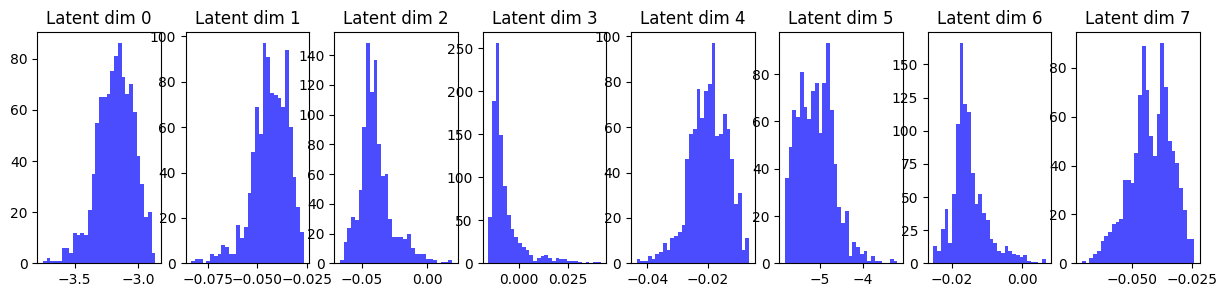

In [80]:
import torch
import matplotlib.pyplot as plt

# 获取一批训练数据
num_samples = 1000
train_samples = torch.tensor(X_train[:num_samples]).to(device)

# 通过编码器得到隐变量
model.eval()
with torch.no_grad():
    encoded, decoded, mu, log_var = model(train_samples)

# 转换为 NumPy 并绘制直方图
encoded_samples = log_var.cpu().numpy()

# 画出每个维度的分布
fig, axes = plt.subplots(1, model.num_hidden, figsize=(15, 3))
for i in range(model.num_hidden):
    axes[i].hist(encoded_samples[:, i], bins=30, alpha=0.7, color='blue')
    axes[i].set_title(f"Latent dim {i}")

plt.show()

Generated Images from Latent Space:


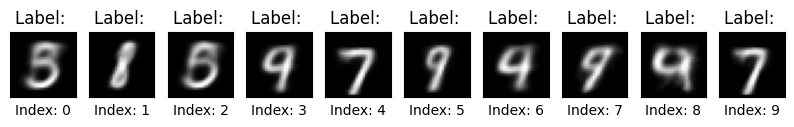

In [120]:
import torch

# 生成 10 个随机的隐空间样本
num_samples = 10
latent_dim = model.num_hidden  # 隐空间的维度
#     generated_images = model.decoder(encoded_samples)  # 直接使用解码器

# 变形为 28x28 并转换为 NumPy 以便可视化
# generated_images = generated_images.cpu().numpy().reshape(-1, 28, 28)
generated_images = model.sample(num_samples).cpu().numpy().reshape(-1, 28, 28)
# 显示生成的图像（不需要标签）
print("Generated Images from Latent Space:")
show_images(generated_images, labels=[""] * num_samples)

Original Images:


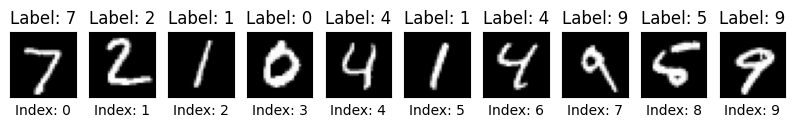

Reconstructed Images:


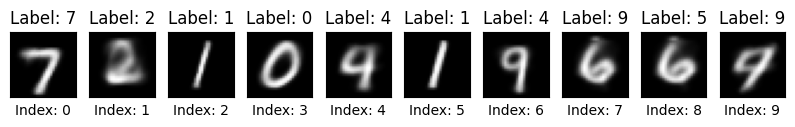

In [126]:
# 验证重构效果

# 选择测试数据（取前 10 张）
num_samples = 10
# test_samples = torch.tensor(X_test[:num_samples])  # 取前 num_samples 个测试样本
# 随机选择测试数据
test_samples = X_test[:num_samples]
test_samples = torch.tensor(test_samples).to(device)  # 转换为张量并移动到设备
test_samples = test_samples.view(-1, 784)  # 确保形状正确

# 进入评估模式
model.eval()

# 关闭梯度计算，加速推理
with torch.no_grad():
    # _, reconstructed,_,_ = model(test_samples)  # 进行前向传播
    encoded = model.encoder(test_samples)
    # Compute the mean and log variance vectors
    mu = model.mu(encoded)
    log_var = model.log_var(encoded)
    # Reparameterize the latent variable
    z = model.reparameterize(mu, log_var)
    # z = mu
    # Pass the latent variable through the decoder
    decoded = model.decoder(z)

test_samples = test_samples.cpu()
reconstructed = decoded.cpu()
# 将数据转换回 NumPy 以便可视化
test_samples = test_samples.numpy().reshape(-1, 28, 28)  # 原始图像
reconstructed = reconstructed.numpy().reshape(-1, 28, 28)  # 生成的重构图像

# 可视化原始图像
print("Original Images:")
show_images(test_samples, y_test[:num_samples])

# 可视化重构图像
print("Reconstructed Images:")
show_images(reconstructed, y_test[:num_samples])

Generated Images from Latent Space:


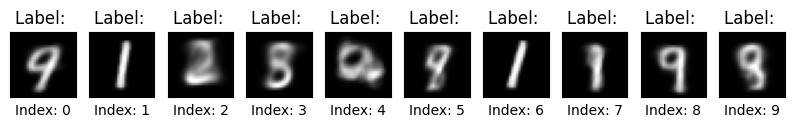

In [127]:
import torch
# 另一种方法是直接使用解码器生成图像，而不是通过解码器重构输入图像。
# 生成 10 个随机的隐空间样本
num_samples = 10
latent_dim = model.num_hidden  # 隐空间的维度
encoded_samples = torch.randn(num_samples, latent_dim).to(device)  # 从 N(0,1) 采样
# 通过解码器生成图像
model.eval()  # 切换到评估模式
with torch.no_grad():
    generated_images = model.decoder(encoded_samples)  # 直接使用解码器

# 变形为 28x28 并转换为 NumPy 以便可视化
generated_images = generated_images.cpu().numpy().reshape(-1, 28, 28)

# 显示生成的图像（不需要标签）
print("Generated Images from Latent Space:")
show_images(generated_images, labels=[""] * num_samples)

Generated Images with One Latent Dimension Changed:


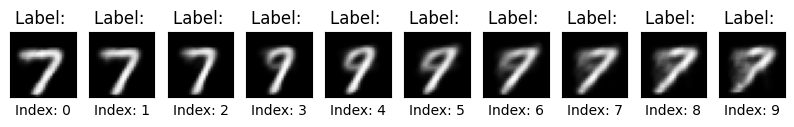

In [131]:
import torch

# 生成一个随机的隐空间向量
latent_dim = model.num_hidden  # 隐空间的维度
# 生成一个随机的初始隐空间向量
base_vector = torch.randn(latent_dim).to(device)

# 选择要改变的分量（这里选择第一个分量）
index_to_change = 0  

# 生成 10 个隐空间样本，每次逐步改变选定的分量
num_samples = 10
change_values = torch.linspace(-2, 2, num_samples).to(device)  # 变化范围可调整
encoded_samples = torch.stack([
    base_vector.clone().detach() for _ in range(num_samples)
])

# 修改选定的分量
for i in range(num_samples):
    encoded_samples[i, index_to_change] = change_values[i]

# 通过解码器生成图像
model.eval()  # 切换到评估模式
with torch.no_grad():
    generated_images = model.decoder(encoded_samples)  # 直接使用解码器

# 变形为 28x28 并转换为 NumPy 以便可视化
generated_images = generated_images.cpu().numpy().reshape(-1, 28, 28)

# 显示生成的图像（不需要标签）
print("Generated Images with One Latent Dimension Changed:")
show_images(generated_images, labels=[""] * num_samples)

In [ ]:
# Training loop
# 用交叉熵损失函数替换均方误差损失函数
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        # Get a batch of training data and move it to the device
        data = data.to(device)

        # Forward pass
        encoded, decoded, mu, log_var = model(data)

        # Compute the loss and perform backpropagation
        # KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = loss_function(decoded, data, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss))

Epoch 1/10: loss=4844.5026
Epoch 2/10: loss=4828.0503
Epoch 3/10: loss=4823.8841
Epoch 4/10: loss=4810.7752
Epoch 5/10: loss=4800.0758
Epoch 6/10: loss=4799.0572
Epoch 7/10: loss=4789.8900
Epoch 8/10: loss=4792.1416
Epoch 9/10: loss=4776.4123
Epoch 10/10: loss=4776.0897
